# Twitter Sentiment Analysis

In [51]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # function for splitting data to train and test sets

import re
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import string
def find_website(string):
  
    # findall() has been used 
    # with valid conditions for urls in string
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    url = re.findall(regex,string)      
    return [x[0] for x in url]



def preprocessor(text):
    
    text = text.lower()
    
    #clean character 
    text=re.sub('<[^>]*>','',text)
    
    ##Add emojis tos the end
    emojis=re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
    text=re.sub('[\W]+',' ',text.lower()) +\
                ' '.join(emojis).replace('-','')
    
    ##removing preposition
    text = ' '.join(word for word in text.split(' ') if word not in string.punctuation)
    
    ##removing tweet specific words
    text = ' '.join(word for word in text.split(' ') if not word.startswith('@') and not word.startswith('#') and 'http' not in word and word != 'RT' )
    
    ##remove url
    website = find_website(text)
    #print(website)
    webdomain = []
    
    for web in website:
        text = text.replace(web,' ')
        domain = urlparse(web).netloc
        webdomain.append(domain)
        
    ##removing stop words
    ##print('removing stop words')
    stop=stopwords.words('english')
    text = [word for word in text.split() if word not in stop]
    text = text + webdomain
    text = ' '.join(text)
    #print(text)
    
    ##Stemming
    porter=PorterStemmer()
    text = [porter.stem(word) for word in text.split()]
    #print(text)
    
    ## Lemitization
    wordnet_lemmatizer = WordNetLemmatizer()
    #temp_df = [wordnet_lemmatizer.lemmatize(w) for w in temp_df]

    return ' '.join(text)
#data['review']=data['review'].apply(preprocessor)

In [39]:
data = pd.read_csv('Sentiment.csv')
# Keeping only the neccessary columns
data = data[['text','sentiment']]

In [40]:
data.head(2)

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive


In [41]:
# Splitting the dataset into train and test set
train, test = train_test_split(data,test_size = 0.1)
# Removing neutral sentiments
train = train[train.sentiment != "Neutral"]

Positive words


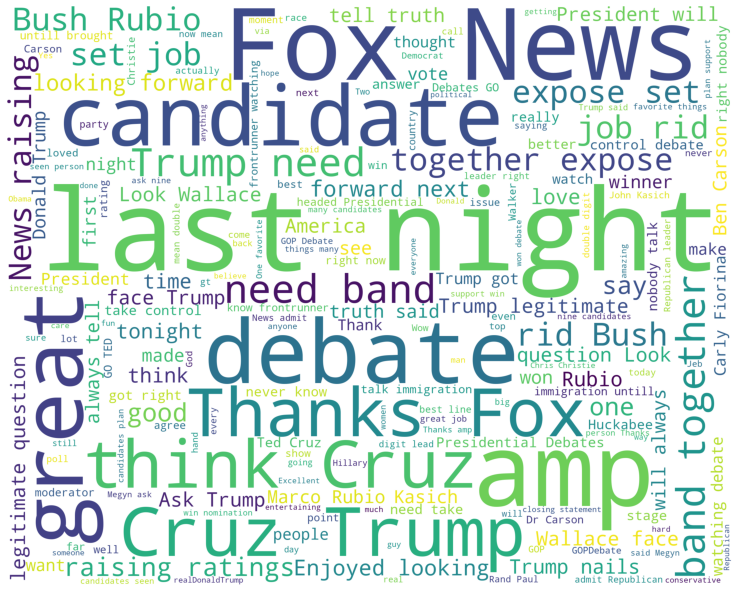

Negative words


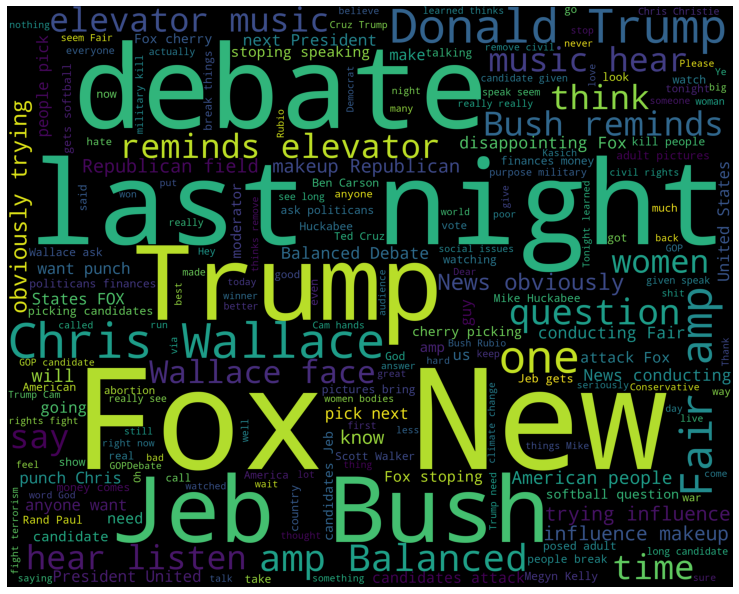

In [42]:
train_pos = train[ train['sentiment'] == 'Positive']
train_pos = train_pos['text']
train_neg = train[ train['sentiment'] == 'Negative']
train_neg = train_neg['text']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

In [43]:
data['text']=data['text'].apply(preprocessor)

<b>Bag of Words</b>

In [45]:
X = np.array(data.iloc[:,0].values)
y = np.array(data.sentiment.values)
cv = CountVectorizer(max_features = 1000)
X = cv.fit_transform(data.text).toarray()
print("X.shape = ",X.shape)
print("y.shape = ",y.shape)

X.shape =  (13871, 1000)
y.shape =  (13871,)


<b> Split train and Test</b>

In [46]:
trainx,testx,trainy,testy = train_test_split(X,y,test_size=0.2,random_state=9)
print("Train shapes : X = {}, y = {}".format(trainx.shape,trainy.shape))
print("Test shapes : X = {}, y = {}".format(testx.shape,testy.shape))

Train shapes : X = (11096, 1000), y = (11096,)
Test shapes : X = (2775, 1000), y = (2775,)


<b>Model Building</b>

In [49]:
gnb,mnb,bnb = GaussianNB(),MultinomialNB(alpha=1.0,fit_prior=True),BernoulliNB(alpha=1.0,fit_prior=True)
gnb.fit(trainx,trainy)
mnb.fit(trainx,trainy)
bnb.fit(trainx,trainy)

BernoulliNB()

<b>Testing and Validating Model</b>

In [52]:
ypg = gnb.predict(testx)
ypm = mnb.predict(testx)
ypb = bnb.predict(testx)

print("Gaussian = ",accuracy_score(testy,ypg))
print("Multinomial = ",accuracy_score(testy,ypm))
print("Bernoulli = ",accuracy_score(testy,ypb))

Gaussian =  0.37765765765765763
Multinomial =  0.6522522522522523
Bernoulli =  0.6472072072072073
